- 이전에 norm&resize만 진행한 데이터에 대한 all finetune과 top freeze finetune을 비교해보며 transfer learning에는 문제 없는 걸 확인했으니 augmentation도 적용해본다

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import pickle

print('z')

z


## Cutmix

In [3]:
def get_clip_box(image_a, image_b, proba = 1.0):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
    
    P = tf.cast( tf.random.uniform([],0,1)<=proba, tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb
# xa, ya, xb, yb = get_clip_box(image_a, image_b)
# print(get_clip_box(image_a, image_b))


In [4]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    return mixed_img

In [5]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = a*label_a + (1-a)*label_b
    return mixed_label

# mixed_label = mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb)
# print(mixed_label)

In [6]:
def cutmix(image, label, prob = 0.666, batch_size=16, img_size=224, num_classes=120, proba = 1.0):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        xa, ya, xb, yb = get_clip_box(image_a, image_b, proba)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup

In [7]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

# mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
# plt.imshow(mixed_img.numpy())
#print(mixed_label)


In [8]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## dataset에 적용

In [9]:
def normalize_and_resize_img_origin(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# # official code normalize (imagenet)
# def normalize_and_resize_img(image, label, mean=[125.3, 123.0, 113.9], std=[63.0, 62.1, 66.7]):
#     """Normalizes images: `uint8` -> `float32`."""
#     image = tf.image.resize(image, [224, 224])
#     R = tf.divide(tf.subtract(image[..., 0], mean[0]), std[0])
#     G = tf.divide(tf.subtract(image[..., 1], mean[1]), std[1])
#     B = tf.divide(tf.subtract(image[..., 2], mean[2]), std[2])
    
#     return tf.cast(tf.stack([R,G,B], axis=-1), tf.float32), label

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [11]:
def base_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])

    return image, label

In [12]:
def onehot(image, label):
    num_classes = 120
    onehot_label = tf.one_hot(label, num_classes)
    return image, onehot_label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img_origin, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test and  with_aug:
        ds = ds.map(
            base_augment
        )
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    elif not with_cutmix and not with_mixup and is_test:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

In [14]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

EPOCH = 10

# ResNet model finetune

## Cutmix model 

In [15]:
import keras.backend as K

base_model = tf.keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        #pooling='avg',
    )

for layer in base_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False


inputs = keras.Input(shape=(224, 224, 3)) 

x = base_model(inputs) 
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
resnet50_freeze_cutmix = keras.Model(inputs, outputs)


# resnet50_freeze_cutmix.summary()

Using TensorFlow backend.


In [16]:
EPOCH = 10

tf.random.set_seed(2020)
resnet50_freeze_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history_resnet50_freeze_cutmix = resnet50_freeze_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_freeze_cutmix.save_weights('resnet50_freeze_cutmix')
with open('./funetune_gist_and_weights/resnet50_freeze_cutmix_hist', 'wb') as file_pi:
    pickle.dump(history_resnet50_freeze_cutmix.history, file_pi)

Train for 750 steps, validate for 536 steps
Epoch 1/10
750/750 [==============================] - 111s 149ms/step - loss: 4.9701 - categorical_accuracy: 0.0160 - val_loss: 4.8431 - val_categorical_accuracy: 0.0354
Epoch 2/10
750/750 [==============================] - 104s 138ms/step - loss: 4.6962 - categorical_accuracy: 0.0398 - val_loss: 3.1201 - val_categorical_accuracy: 0.2966
Epoch 3/10
750/750 [==============================] - 104s 138ms/step - loss: 4.5660 - categorical_accuracy: 0.0556 - val_loss: 2.7515 - val_categorical_accuracy: 0.3886
Epoch 4/10
750/750 [==============================] - 103s 137ms/step - loss: 4.4954 - categorical_accuracy: 0.0619 - val_loss: 2.5419 - val_categorical_accuracy: 0.4488
Epoch 5/10
750/750 [==============================] - 103s 137ms/step - loss: 4.4501 - categorical_accuracy: 0.0734 - val_loss: 2.4324 - val_categorical_accuracy: 0.4622
Epoch 6/10
750/750 [==============================] - 103s 137ms/step - loss: 4.4221 - categorical_accurac

In [17]:
history_resnet50_freeze_cutmix = pickle.load(open('./funetune_gist_and_weights/resnet50_freeze_cutmix_hist', "rb"))

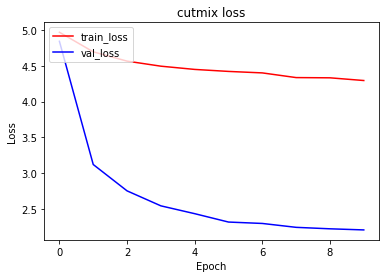

In [18]:
plt.plot(history_resnet50_freeze_cutmix['loss'], 'r')
plt.plot(history_resnet50_freeze_cutmix['val_loss'], 'b')
plt.title('cutmix loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

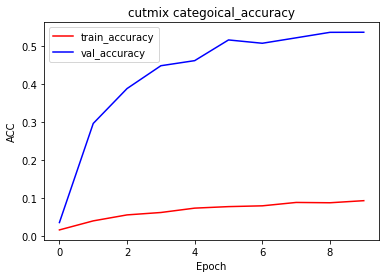

In [19]:
plt.plot(history_resnet50_freeze_cutmix['categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze_cutmix['val_categorical_accuracy'], 'b')
plt.title('cutmix categoical_accuracy')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

- 기존에 cutmix적용 data를 all finetune했던 model과 같이 cutmix를 적용하여 top finetune (+base augment)한 model은 train data보다 val data의 loss가 낮고 acc가 높다
    - 이전에 aug 적용 안시킨 freeze model에 BN layer를 trainable = False로 두고 sparse_categorical_loss를 썻을때는 반대 현상이나옴
        - 이전엔 test때 BN의 moving average가 적용되지 않아 그런것 이었다고 생각함
    - 첫 실험인 all finetune때도 그랬는데 이번에도 똑같다???
        - aug를 적용시킨 (cutmix포함) dataset의 분포가 pre-trained 된 모델의 ImageNet datsets이랑 (전처리과정이) 너무 차이가 난다고 일단 뇌피셜로 해석해봄

- 비교 ㄱㄱ

In [27]:
cutmix_hist = pickle.load(open('./aug_history_and_weights/resnet50_cutmix_hist', "rb"))
mixup_hist = pickle.load(open('./aug_history_and_weights//resnet50_mixup_hist', "rb"))

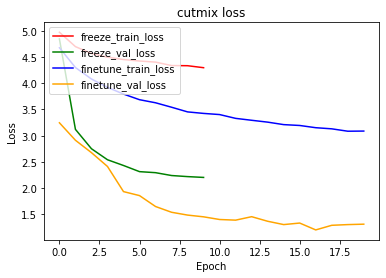

In [29]:
plt.plot(history_resnet50_freeze_cutmix['loss'], 'r')
plt.plot(history_resnet50_freeze_cutmix['val_loss'], 'g')
plt.plot(cutmix_hist['loss'], 'b')
plt.plot(cutmix_hist['val_loss'], 'orange')
plt.title('cutmix loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['freeze_train_loss', 'freeze_val_loss', 'finetune_train_loss', 'finetune_val_loss'], loc='upper left')
plt.show()

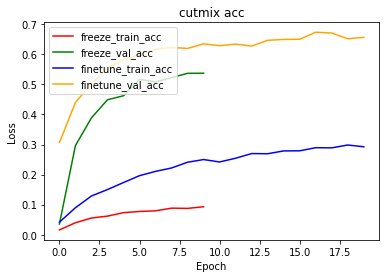

In [31]:
plt.plot(history_resnet50_freeze_cutmix['categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze_cutmix['val_categorical_accuracy'], 'g')
plt.plot(cutmix_hist['categorical_accuracy'], 'b')
plt.plot(cutmix_hist['val_categorical_accuracy'], 'orange')
plt.title('cutmix acc')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['freeze_train_acc', 'freeze_val_acc', 'finetune_train_acc', 'finetune_val_acc'], loc='upper left')
plt.show()

- 그래프 형태는 비슷하지만(val loss가 train loss보다 낮음) freeze+aug가 all finetune 한 것보다 loss가 높다

## MixUp

In [20]:
import keras.backend as K

base_model = tf.keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        #pooling='avg',
    )

for layer in base_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False


inputs = keras.Input(shape=(224, 224, 3)) 

x = base_model(inputs) 
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)
resnet50_freeze_mixup = keras.Model(inputs, outputs)


# resnet50_freeze_cutmix.summary()

In [21]:
EPOCH = 10

tf.random.set_seed(2020)
resnet50_freeze_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history_resnet50_freeze_mixup = resnet50_freeze_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_freeze_mixup.save_weights('resnet50_freeze_mixup')
with open('./funetune_gist_and_weights/resnet50_freeze_mixup_hist', 'wb') as file_pi:
    pickle.dump(history_resnet50_freeze_mixup.history, file_pi)

Train for 750 steps, validate for 536 steps
Epoch 1/10
750/750 [==============================] - 109s 145ms/step - loss: 4.5250 - categorical_accuracy: 0.0815 - val_loss: 5.9027 - val_categorical_accuracy: 0.0282
Epoch 2/10
750/750 [==============================] - 102s 136ms/step - loss: 3.7236 - categorical_accuracy: 0.2303 - val_loss: 2.8215 - val_categorical_accuracy: 0.3087
Epoch 3/10
750/750 [==============================] - 103s 137ms/step - loss: 3.3791 - categorical_accuracy: 0.3183 - val_loss: 2.5118 - val_categorical_accuracy: 0.3807
Epoch 4/10
750/750 [==============================] - 100s 133ms/step - loss: 3.2298 - categorical_accuracy: 0.3672 - val_loss: 2.5159 - val_categorical_accuracy: 0.3780
Epoch 5/10
750/750 [==============================] - 97s 130ms/step - loss: 3.1170 - categorical_accuracy: 0.4128 - val_loss: 2.4524 - val_categorical_accuracy: 0.3951
Epoch 6/10
750/750 [==============================] - 97s 130ms/step - loss: 3.0568 - categorical_accuracy:

In [22]:
history_resnet50_freeze_mixup = pickle.load(open('./funetune_gist_and_weights/resnet50_freeze_mixup_hist', "rb"))

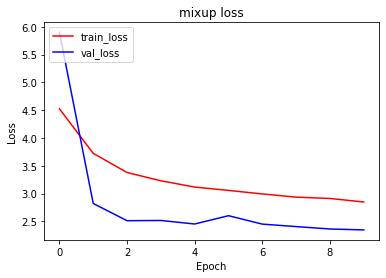

In [23]:
plt.plot(history_resnet50_freeze_mixup['loss'], 'r')
plt.plot(history_resnet50_freeze_mixup['val_loss'], 'b')
plt.title('mixup loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

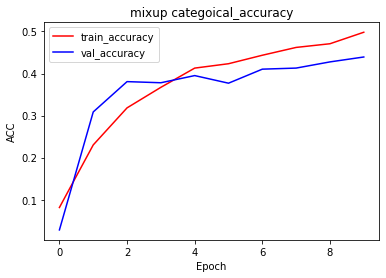

In [24]:
plt.plot(history_resnet50_freeze_mixup['categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze_mixup['val_categorical_accuracy'], 'b')
plt.title('mixup categoical_accuracy')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

- mixup은 그래프자체는 그나마 정상이지만 모양만 정상이지 cutmix에 비해 val_loss가 너무 높고 val_acc가 너무 낮다

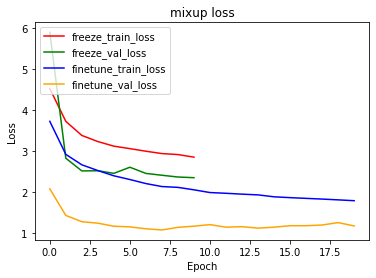

In [32]:
plt.plot(history_resnet50_freeze_mixup['loss'], 'r')
plt.plot(history_resnet50_freeze_mixup['val_loss'], 'g')
plt.plot(mixup_hist['loss'], 'b')
plt.plot(mixup_hist['val_loss'], 'orange')
plt.title('mixup loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['freeze_train_loss', 'freeze_val_loss', 'finetune_train_loss', 'finetune_val_loss'], loc='upper left')
plt.show()

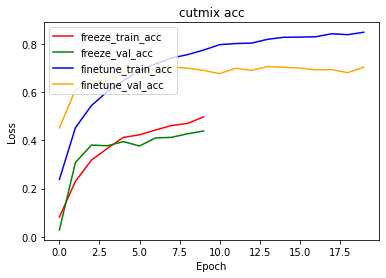

In [33]:
plt.plot(history_resnet50_freeze_mixup['categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze_mixup['val_categorical_accuracy'], 'g')
plt.plot(mixup_hist['categorical_accuracy'], 'b')
plt.plot(mixup_hist['val_categorical_accuracy'], 'orange')
plt.title('cutmix acc')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['freeze_train_acc', 'freeze_val_acc', 'finetune_train_acc', 'finetune_val_acc'], loc='upper left')
plt.show()

- 역시나 freeze + aug적용한 것이 성능이 좋지 못함
    - 일단 mixup은 pre-trained 사용할거면 all finetune 해야할 듯

### Cutmix VS MixUp

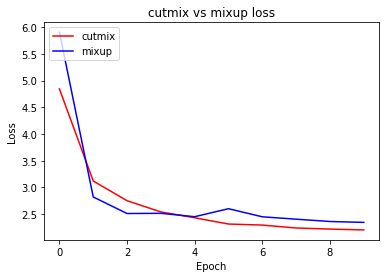

In [25]:
plt.plot(history_resnet50_freeze_cutmix['val_loss'], 'r')
plt.plot(history_resnet50_freeze_mixup['val_loss'], 'b')
plt.title('cutmix vs mixup loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['cutmix', 'mixup'], loc='upper left')
plt.show()

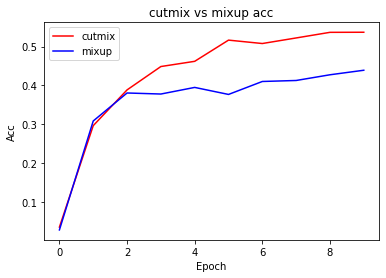

In [26]:
plt.plot(history_resnet50_freeze_cutmix['val_categorical_accuracy'], 'r')
plt.plot(history_resnet50_freeze_mixup['val_categorical_accuracy'], 'b')
plt.title('cutmix vs mixup acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['cutmix', 'mixup'], loc='upper left')
plt.show()

- 그지 꼴이 따로없다.
    - 둘다 val loss가 너무 높고, val acc가 너무 낮음

## 이번실험 결론

- BN이 들어간 모델 혹은 pre-training된 모델의 데이터셋과 전처리 상태에따라 fine-tune (일부 top layer만) 하는데 고려해야할 사항이 너무 많다(스케쥴링도 생각해봐야할듯...).